# 双向循环神经网络
:label:`sec_bi_rnn`

在序列学习中，我们以往假设的目标是：到目前为止，在给定观测的情况下对下一个输出进行建模。例如，在时间序列的上下文中或在语言模型的上下文中。虽然这是一个典型的情况，但这并不是我们可能遇到的唯一情况。为了说明这个问题，考虑以下三个在文本序列中填空的任务：

* 我 `___`。
* 我 `___` 饿了。
* 我 `___` 饿了，我可以吃半头猪。

根据可获得的信息量，我们可以用不同的词填空，如“很高兴”（"happy"）、“不”（"not"）和“非常”（"very"）。很明显，短语的结尾（如果有的话）传达了重要信息，而这些信息关乎到选择哪个词来填空，所以不能利用这一点的序列模型将在相关任务上表现不佳。例如，如果要做好命名实体识别（例如，识别“Green”指的是“格林先生”还是绿色），不同长度的上下文范围重要性是相同的。为了获得一些解决问题的灵感，让我们先迂回到概率图模型。

## 隐马尔可夫模型中的动态规划

这一小节是用来说明动态规划问题的，具体的技术细节对于理解深度学习模型并不重要，但它们有助于人们思考为什么要使用深度学习，以及为什么要选择特定的结构。

如果我们想用概率图模型来解决这个问题，可以设计一个隐变量模型，如下图所示。在任意时间步 $t$，假设存在某个隐变量 $h_t$，通过概率 $P(x_t \mid h_t)$ 控制我们观测到的发射 $x_t$。此外，任何转移 $h_t \to h_{t+1}$ 都是由一些状态转移概率 $P(h_{t+1} \mid h_{t})$ 给出。这个概率图模型就是一个 *隐马尔可夫模型*（hidden Markov model，HMM），如 :numref:`fig_hmm` 所示。

![隐马尔可夫模型。](../img/hmm.svg)
:label:`fig_hmm`

因此，对于有 $T$ 个观测值的序列，我们在观测状态和隐藏状态上具有以下联合概率分布：

$$P(x_1, \ldots, x_T, h_1, \ldots, h_T) = \prod_{t=1}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t), \text{ where } P(h_1 \mid h_0) = P(h_1).$$
:eqlabel:`eq_hmm_jointP`

现在假设我们观测到所有的 $x_i$，除了 $x_j$，并且我们的目标是计算 $P(x_j \mid x_{-j})$，其中 $x_{-j} = (x_1, \ldots, x_{j-1}, x_{j+1}, \ldots, x_{T})$。由于 $P(x_j \mid x_{-j})$ 中没有隐变量，因此我们考虑对 $h_1, \ldots, h_T$ 的选择构成的所有可能的组合进行求和。如果任何 $h_i$ 可以接受 $k$ 个不同的值（有限的状态数），这意味着我们需要对 $k^T$ 个项求和，这个任务是不可能完成的！幸运的是，有一个优雅的解决方案——*动态规划*（dynamic programming）。

要了解它的工作方式，请考虑对隐变量 $h_1, \ldots, h_T$ 的依次求和。根据 :eqref:`eq_hmm_jointP`，将得出：

$$\begin{aligned}
    &P(x_1, \ldots, x_T) \\
    =& \sum_{h_1, \ldots, h_T} P(x_1, \ldots, x_T, h_1, \ldots, h_T) \\
    =& \sum_{h_1, \ldots, h_T} \prod_{t=1}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t) \\
    =& \sum_{h_2, \ldots, h_T} \underbrace{\left[\sum_{h_1} P(h_1) P(x_1 \mid h_1) P(h_2 \mid h_1)\right]}_{\pi_2(h_2) \stackrel{\mathrm{def}}{=}}
    P(x_2 \mid h_2) \prod_{t=3}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t) \\
    =& \sum_{h_3, \ldots, h_T} \underbrace{\left[\sum_{h_2} \pi_2(h_2) P(x_2 \mid h_2) P(h_3 \mid h_2)\right]}_{\pi_3(h_3)\stackrel{\mathrm{def}}{=}}
    P(x_3 \mid h_3) \prod_{t=4}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t)\\
    =& \dots \\
    =& \sum_{h_T} \pi_T(h_T) P(x_T \mid h_T).
\end{aligned}$$

通常，我们将“前向递归”（forward recursion）写为：

$$\pi_{t+1}(h_{t+1}) = \sum_{h_t} \pi_t(h_t) P(x_t \mid h_t) P(h_{t+1} \mid h_t).$$

递归被初始化为 $\pi_1(h_1) = P(h_1)$。符号简化，也可以写成 $\pi_{t+1} = f(\pi_t, x_t)$，其中 $f$ 是一些可学习的函数。这看起来就像我们在循环神经网络中讨论的隐变量模型中的更新方程。

与前向递归一样，我们也可以使用后向递归对同一组隐变量求和。这将得到：

$$\begin{aligned}
    & P(x_1, \ldots, x_T) \\
     =& \sum_{h_1, \ldots, h_T} P(x_1, \ldots, x_T, h_1, \ldots, h_T) \\
    =& \sum_{h_1, \ldots, h_T} \prod_{t=1}^{T-1} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot P(h_T \mid h_{T-1}) P(x_T \mid h_T) \\
    =& \sum_{h_1, \ldots, h_{T-1}} \prod_{t=1}^{T-1} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot
    \underbrace{\left[\sum_{h_T} P(h_T \mid h_{T-1}) P(x_T \mid h_T)\right]}_{\rho_{T-1}(h_{T-1})\stackrel{\mathrm{def}}{=}} \\
    =& \sum_{h_1, \ldots, h_{T-2}} \prod_{t=1}^{T-2} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot
    \underbrace{\left[\sum_{h_{T-1}} P(h_{T-1} \mid h_{T-2}) P(x_{T-1} \mid h_{T-1}) \rho_{T-1}(h_{T-1}) \right]}_{\rho_{T-2}(h_{T-2})\stackrel{\mathrm{def}}{=}} \\
    =& \ldots \\
    =& \sum_{h_1} P(h_1) P(x_1 \mid h_1)\rho_{1}(h_{1}).
\end{aligned}$$

因此，我们可以将“后向递归”（backward recursion）写为：

$$\rho_{t-1}(h_{t-1})= \sum_{h_{t}} P(h_{t} \mid h_{t-1}) P(x_{t} \mid h_{t}) \rho_{t}(h_{t}),$$

初始化 $\rho_T(h_T) = 1$。前向和后向递归都允许我们对 $T$ 个隐变量在 $\mathcal{O}(kT)$（线性而不是指数）时间内对 $(h_1, \ldots, h_T)$ 的所有值求和。这是使用图模型进行概率推理的巨大好处之一。它也是通用消息传递算法 :cite:`Aji.McEliece.2000` 的一个非常特殊的例子。结合前向和后向递归，我们能够计算

$$P(x_j \mid x_{-j}) \propto \sum_{h_j} \pi_j(h_j) \rho_j(h_j) P(x_j \mid h_j).$$

注意到因为符号简化的需要，后向递归也可以写为 $\rho_{t-1} = g(\rho_t, x_t)$，其中 $g$ 是一个可以学习的函数。同样，这看起来非常像一个更新方程，只是不像我们在循环神经网络中看到的那样前向运算，而是后向计算。事实上，知道未来数据何时可用对隐马尔可夫模型是有益的。信号处理科学家将是否知道未来观测这两种情况区分为内插和外推。有关更多详细信息，请参阅一本书 :cite:`Doucet.De-Freitas.Gordon.2001`。

## 双向模型

如果我们希望在循环神经网络中拥有一种机制，使之能够提供与隐马尔可夫模型类似的前瞻能力，我们就需要修改循环神经网络的设计。幸运的是，这在概念上很容易，只需要增加一个从最后一个词元开始从后向前运行的循环神经网络，而不是只有一个在前向模式下从第一个词元开始运行的循环神经网络。
*双向循环神经网络*（bidirectional RNNs）添加了反向传递信息的隐藏层，以便更灵活地处理此类信息。 :numref:`fig_birnn` 描述了具有单个隐藏层的双向循环神经网络的结构。

![双向循环神经网络的结构。](../img/birnn.svg)
:label:`fig_birnn`

事实上，这与隐马尔可夫模型中的动态规划的前向和后向递归没有太大区别。其主要区别是，在隐马尔可夫模型中的方程具有特定的统计意义。双向循环神经网络没有这样容易理解的解释，我们只能把它们当作通用的、可学习的函数。这种转变集中体现了现代深度网络的设计原则：首先使用的是经典统计模型的函数依赖类型，然后将其参数化为通用形式。



### 定义

双向循环神经网络是由 :cite:`Schuster.Paliwal.1997` 提出的，关于各种结构的详细讨论请参阅 :cite:`Graves.Schmidhuber.2005`。让我们看看这样一个网络的细节。

对于任意时间步 $t$，给定一个小批量的输入数据 $\mathbf{X}_t \in \mathbb{R}^{n \times d}$（样本数：$n$，每个示例中的输入数：$d$），并且令隐藏层激活函数为$\phi$。在双向结构中，我们设该时间步的前向和反向隐藏状态分别为 $\overrightarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$ 和 $\overleftarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$，其中 $h$ 是隐藏单元的数目。前向和反向隐藏状态的更新如下：

$$
\begin{aligned}
\overrightarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(f)} + \overrightarrow{\mathbf{H}}_{t-1} \mathbf{W}_{hh}^{(f)}  + \mathbf{b}_h^{(f)}),\\
\overleftarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(b)} + \overleftarrow{\mathbf{H}}_{t+1} \mathbf{W}_{hh}^{(b)}  + \mathbf{b}_h^{(b)}),
\end{aligned}
$$

其中，权重 $\mathbf{W}_{xh}^{(f)} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh}^{(f)} \in \mathbb{R}^{h \times h}, \mathbf{W}_{xh}^{(b)} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh}^{(b)} \in \mathbb{R}^{h \times h}$  和偏置 $\mathbf{b}_h^{(f)} \in \mathbb{R}^{1 \times h}, \mathbf{b}_h^{(b)} \in \mathbb{R}^{1 \times h}$ 都是模型参数。

接下来，将前向隐藏状态 $\overrightarrow{\mathbf{H}}_t$ 和反向隐藏状态 $\overleftarrow{\mathbf{H}}_t$ 连续起来，获得需要送入输出层的隐藏状态 $\mathbf{H}_t \in \mathbb{R}^{n \times 2h}$。在具有多个隐藏层的深度双向循环神经网络中，该信息作为输入传递到下一个双向层。最后，输出层计算得到的输出为 $\mathbf{O}_t \in \mathbb{R}^{n \times q}$（$q$ 是输出单元的数目）：

$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q.$$

这里，权重矩阵 $\mathbf{W}_{hq} \in \mathbb{R}^{2h \times q}$ 和偏置 $\mathbf{b}_q \in \mathbb{R}^{1 \times q}$ 是输出层的模型参数。事实上，这两个方向可以拥有不同数量的隐藏单元。



### 模型的计算成本及其应用

双向循环神经网络的一个关键特性是，使用来自序列两端的信息来估计输出。也就是说，我们使用来自过去和未来的观测信息来预测当前的观测。但是在对下一个词元进行预测的案例中，这样的行为并不是我们想要的。因为在预测下一个词元时，我们终究是无法知道下一个词元的下一个是什么。因此，如果我们幼稚地基于双向循环神经网络进行预测时，将不会得到很好的准确性：因为在训练期间，我们能够利用过去和未来的数据来估计现在，而在测试期间，我们只有过去的数据，因此准确性将会很差。下面，我们将在实验中说明这一点。

另一个严重问题是，双向循环神经网络的计算速度非常慢。其主要原因是网络的前向传播需要在双向层中进行前向和后向递归，并且网络的反向传播还依赖于前向传播的结果。因此，梯度求解将有一个非常长的依赖链。

双向层的使用在实践中非常少，并且仅仅应用于部分场合。例如，填充缺失的单词、词元注释（例如，用于命名实体识别）以及作为序列处理工作流中的一个步骤对序列进行编码（例如，用于机器翻译）。在 :numref:`sec_bert` 和 :numref:`sec_sentiment_rnn` 中，我们将介绍如何使用双向循环神经网络编码文本序列。

## (**双向循环神经网络的错误应用**)

众所周知，双向循环神经网络使用了过去的和未来的数据这是事实，而如果我们忽略基于事实的那些建议，并将其应用于语言模型，那么我们也能得到令人可以接受的困惑度估计。尽管如此，如下面的实验所示，该模型预测未来词元的能力也存在严重的缺陷。尽管困惑度是合理的，但是经过多次迭代模型也只能生成乱码。我们用下面的代码引以为戒，以防在错误的环境中使用它们。


time traveller                                                  


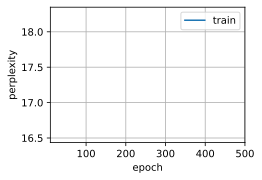

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

# 加载数据
batch_size, num_steps, device = 32, 35, d2l.try_gpu()
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
# 通过设置'bidirective=True'来定义双向LSTM模型
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
# 训练模型
num_epochs, lr = 500, 1
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

基于上述原因，结果显然令人失望。关于如何更有效地使用双向循环神经网络的讨论，请参阅 :numref:`sec_sentiment_rnn` 中的情感分类应用。

## 小结

* 在双向循环神经网络中，每个时间步的隐藏状态由当前时间步的前后数据同时决定。
* 双向循环神经网络与概率图模型中的“前向-后向”算法有着惊人的相似性。
* 双向循环神经网络主要用于序列编码和给定双向上下文的观测估计。
* 由于梯度链更长，因此双向循环神经网络的训练成本非常高。

## 练习

1. 如果不同方向使用不同数量的隐藏单位，$\mathbf{H_t}$ 的形状会发生怎样的变化？
1. 设计一个具有多个隐藏层的双向循环神经网络。
1. 在自然语言中一词多义很常见。例如，“bank”一词在不同的上下文“i went to the bank to deposit cash”和“i went to the bank to sit down”中有不同的含义。如何设计一个神经网络模型，使其在给定上下文序列和单词的情况下，返回该单词在此上下文中的向量表示？哪种类型的神经网络结构更适合处理一词多义？


[Discussions](https://discuss.d2l.ai/t/2773)
